In [3]:
__author__ = 'jcorrea'

# Data dependencies
import h5py
import pickle
import numpy as np
import numpy.ma as ma
from matplotlib.pyplot import plot as plt, imshow
from sklearn.preprocessing import normalize
import neon

In [ ]:
# neon dependencies
import logging
import neon
import neon.backends
from neon.backends import gen_backend
from neon.layers import FCLayer, DataLayer, CostLayer
from neon.models import MLP
from neon.transforms import RectLin, Logistic, CrossEntropy
from neon.datasets import MNIST
from neon.experiments import FitPredictErrorExperiment
#import ipdb

logging.basicConfig(level=20)
logger = logging.getLogger()


(-0.5, 223.5, 157.5, -0.5)

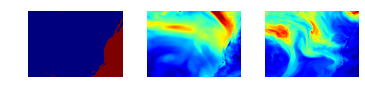

In [61]:
# Land-mask and TMQ data for AR/nAR
fland = "/Users/DOE6903584/NERSC/mantissa/joaquin/AR/final/data/landmask_imgs.pkl"
far = "/Users/DOE6903584/NERSC/mantissa/joaquin/AR/final/data/atmosphericriver_TMQ.h5"

dland = np.asarray(pickle.load(open(fland, 'r'))['mask'])
darnar = h5py.File(far, 'r')

dar = np.asarray(darnar['AR'])
dnar = np.asarray(darnar['Non_AR'])

%matplotlib inline

# Land-mask
plt.subplot(3, 3, 1)
imshow(dland[0])
plt.axis('off')

# AR
plt.subplot(3, 3, 2)
imshow(dar[0][0])
plt.axis('off')

# nAR
plt.subplot(3, 3, 3)
imshow(dnar[0][0])
plt.axis('off')


(-0.5, 223.5, 157.5, -0.5)

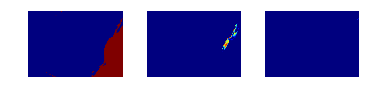

In [62]:
# TMQ thresholding
tmq_thr = 20
dar_i = np.multiply(dar, dland).clip(tmq_thr)
dnar_i = np.multiply(dnar, dland).clip(tmq_thr)

%matplotlib inline

# Land-mask
plt.subplot(3, 3, 1)
imshow(dland[0])
plt.axis('off')

# Thresholded AR
plt.subplot(3, 3, 2)
imshow(dar_i[0][0])
plt.axis('off')

# Thresholded nAR
plt.subplot(3, 3, 3)
imshow(dnar_i[0][0])
plt.axis('off')

In [63]:
# TR/TE sizes for AR/nAR

tr_size_ar = 2000
tr_size_nar = 2000

te_size_ar = 468
te_size_nar = 1077

l_ar = np.ones(tr_size_ar + te_size_ar)
l_nar = np.zeros(tr_size_nar + te_size_nar)

s = range(len(dar))
d = range(len(dnar))
np.random.shuffle(s)
np.random.shuffle(d)

tr_ar = dar[s][:][:][:tr_size_ar]
tr_nar = dnar[d][:][:][:tr_size_nar]

te_ar = dar[s][:][:][-te_size_ar:]
te_nar = dnar[d][:][:][-te_size_nar:]

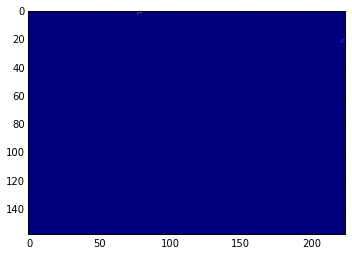

In [39]:
# imshow(np.multiply(dnar, dland)[1000][0].clip(20))

# plt.subplot(2, 1, 1)
imshow(np.multiply(dnar, dland)[0][0].clip(tmq_thr))
# plt.axis('off')

# plt.subplot(2, 1, 2)
# imshow(np.multiply(dnar, dland)[100][0].clip(tmq_thr))
# plt.axis('off')

# plt.subplot(2, 1, 3)
# imshow(np.multiply(dnar, dland)[200][0].clip(20))
# plt.axis('off')

# plt.subplot(2, 1, 4)
# imshow(np.multiply(dnar, dland)[300][0].clip(20))
# plt.axis('off')

# plt.show()

In [48]:
# dnar.shape
np.multiply(dnar, dland)[2][0].shape

(158, 224)

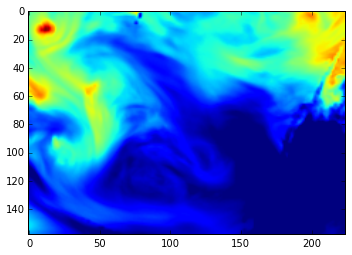

In [55]:
imshow(dnar[1000][0].clip(20))

In [59]:
np.multiply(dland[0], dar[2466][0]).flatten().max()

41.566437

In [ ]:
# neon model

def create_model(nin):
    layers = []
    layers.append(DataLayer(nout=nin, name='input'))
    layers.append(FCLayer(nout=100, activation=RectLin(), name='h0'))
    layers.append(FCLayer(nout=10, activation=Logistic(), name='h1'))
    layers.append(CostLayer(cost=CrossEntropy(), name='y'))
    model = MLP(num_epochs=10, batch_size=128, layers=layers)
    return model
	
def run():
    model = create_model(nin=784)
    backend = gen_backend(rng_seed=0)
    backend = gen_backend(model=model, gpu=None, nrv=False, datapar=False, modelpar=False,
                    flexpoint=False, rng_seed=0, numerr_handling=None,
                    half=False, stochastic_round=0, device_id=None)
    backend = neon.backends.cpu.CPU(rng_seed=0, seterr_handling = {'all':'warn'})
#     dataset = MNIST(repo_path='~/data/')
    experiment = FitPredictErrorExperiment(model=model,
                                           backend=backend,
                                           dataset=dataset)
    experiment.run()


if __name__ == '__main__':
    run()